$W \in R^{k \times m}$, $V \in R^{m \times d}$

$f_\theta(x) = WVx$, where $\theta = \{W,V\}$,

MSE loss: $L(\theta) = \frac{1}{n} \sum_{i=1}^n l(\theta; (x_i,y_i)) = \frac{1}{n} \sum_{i=1}^n \|y_i - WVx_i \|^2$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
import time
from IPython.display import display, Latex

from torch.distributions.multivariate_normal import MultivariateNormal
from datetime import datetime

In [ ]:
torch.set_default_dtype(torch.float64)

In [2]:
# Create model of linear NN with L hidden layers
# input dim = d, hidden dim = m, output dim = k
class Linear_NN(nn.Module):
    def __init__(self,d,m,k,L):
        """
            d: input dimension
            m: hidden layer dimension 
            k: output dimension
            L: number of hidden layers
        """
        super().__init__()
        
        self.L = L
        self.lin_out = nn.Linear(m, k, bias=False)
        self.lin_in = nn.Linear(d, m, bias=False)
        
        self.lin_hidden = nn.ModuleList([nn.Linear(m, m, bias=False) for i in range(self.L)])
        
        
    def forward(self, xb):
        xb = self.lin_in(xb)
        
        for i in range(self.L):
            xb = self.lin_hidden[i](xb)
            
        xb = self.lin_out(xb)
        
        return xb
    
    def init_weights(self, init_type):
        if init_type == 'kaiming_normal':
            torch.nn.init.kaiming_normal_(self.lin_in.weight, nonlinearity='linear')
            torch.nn.init.kaiming_normal_(self.lin_out.weight, nonlinearity='linear')
            for i in range(self.L):
                torch.nn.init.kaiming_normal_(self.lin_hidden[i].weight, nonlinearity='linear')
        elif init_type == 'kaiming_uniform':
            torch.nn.init.kaiming_uniform_(self.lin_in.weight, nonlinearity='linear')
            torch.nn.init.kaiming_uniform_(self.lin_out.weight, nonlinearity='linear')
            for i in range(self.L):
                torch.nn.init.kaiming_uniform_(self.lin_hidden[i].weight, nonlinearity='linear')
        elif init_type == 'xavier_normal':
            torch.nn.init.xavier_normal_(self.lin_in.weight)
            torch.nn.init.xavier_normal_(self.lin_out.weight)
            for i in range(self.L):
                torch.nn.init.xavier_normal_(self.lin_hidden[i].weight)
        elif init_type == 'xavier_uniform':
            torch.nn.init.xavier_uniform_(self.lin_in.weight, nonlinearity='linear')
            torch.nn.init.xavier_uniform_(self.lin_out.weight, nonlinearity='linear')
            for i in range(self.L):
                torch.nn.init.xavier_uniform_(self.lin_hidden[i].weight, nonlinearity='linear')
        else:
            print('Unknown initialization. Using Kaiming normal initialization')
            torch.nn.init.kaiming_normal_(self.lin1.weight, nonlinearity='linear')
            torch.nn.init.kaiming_normal_(self.lin2.weight, nonlinearity='linear')
            for i in range(self.L):
                torch.nn.init.kaiming_normal_(self.lin_hidden[i].weight, nonlinearity='linear')

## 1-hidden linear layer

- Wide hidden layer: $m \in \{200, 500, 1000, 2000\} > d = m = 50$

- Gaussian sampled data with input covariance $\sum_{i=1}^{n} x_ix_i^T = \Sigma_{xx} \approx I$

In [31]:
d = 50 # input dimension
ms = [200, 500, 1000, 2000] # hidden layer dimension
k = 50 # output dimension
L = 0 # number of hidden layers of dim "m"


num_param_1hl = [] # count the number of parameters in the model
Linear_Networks_1hl = []

# initiate linear networks of given depth L[l] with m1 hidden units each
for m in ms:
    Linear_Networks_1hl.append(Linear_NN(d,m,k,L))
    
    # count the number of parameters in the model
    num_param_1hl.append(sum(p.numel() for p in Linear_NN(d,m,k,L).parameters())) 

In [7]:
rep = 500

H_o_tilde_cond_kaiming_1hl = []
H_o_cond_upper_bounds_1hl = []

cov_x = torch.eye(d)

# define multi-variate normal generator with unit matrix as variance
mvrn_d = MultivariateNormal(torch.zeros(d),cov_x)
mvrn_k = MultivariateNormal(torch.zeros(k),torch.eye(k))

# sample n (input,output) tuples
n = 10000
x = mvrn_d.rsample((n,))    
y = mvrn_k.rsample((n,))

# calculate the empirical input covariance matrix and its condition number
cov_xx = x.T @ x / n

cond_cov_xx = np.linalg.cond(cov_xx)

# do the calculations for each l in L
for ind in range(len(ms)):
    start_timestamp = datetime.now()
    
    print('Calculations for m =', ms[ind])
    # repeat the calculation at initialization for "rep" times
    H_o_tilde_cond_1hl = []
    
    H_o_tilde_cond_1hl_upper_bound = []
    
    for i in range(rep):

        if i%1000 == 0:
            print('iter: ', i)

        # initialize the weight matrices according to the defined initialization
        Linear_Networks_1hl[ind].init_weights('kaiming_normal')
                

        UT_U = torch.zeros((k*d,k*d))
        
        V_kaiming = Linear_Networks_1hl[ind].lin_in.weight.detach()
        W_kaiming = Linear_Networks_1hl[ind].lin_out.weight.detach()


        # calculate the outer Hessian product according to the expression derived by Sidak
        H_o_tilde = torch.kron(W_kaiming @ W_kaiming.T, cov_xx) + \
                    torch.kron( torch.eye(k), V_kaiming.T @ V_kaiming @ cov_xx)
        
        H_o_tilde_cond_1hl.append(torch.linalg.cond(H_o_tilde))
      
    
    H_o_tilde_cond_kaiming_1hl.append(H_o_tilde_cond_1hl)
       
    print('Time elapsed: ',(datetime.now() - start_timestamp).total_seconds())

Calculations for m = 200
iter:  0
Time passed:  502.366297
Calculations for m = 500
iter:  0
Time passed:  998.441834
Calculations for m = 1000
iter:  0
Time passed:  1037.969153
Calculations for m = 2000
iter:  0
Time passed:  986.232254


In [8]:
# condition number of input covariance Sigma
kappa_sigma = torch.linalg.cond(cov_xx)
# kappa_sigma
display(Latex(f'Input covariance $\Sigma_{{xx}}={kappa_sigma}$'))


<IPython.core.display.Latex object>

In [9]:
print('Average condition number of the outer product Hessian:')

for ind, m in enumerate(ms):
    display(Latex(f'$\mathbb{{E}}[\kappa(\\tilde{{H}}_{{kai,o,m={m}}})]={np.mean(H_o_tilde_cond_kaiming_1hl[ind])}$'))



Average condition number of the outer product Hessian:


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [32]:
t = 3
prob = 1 - 8 * np.exp(-t**2/2)
m = np.array(ms)

kappa_sigma = 1

display(Latex(r'Upper bound of outer product Hessian with high probability: $p = 1 - 8 \exp(-t^2/2)$'))
display(Latex(f'For $t = {t}$, $p = {prob}$'))


# if np.minimum(np.sqrt(m)-np.sqrt(k)-t,np.sqrt(m)-np.sqrt(d)-t) < 0:
#     print('Invalid choice of t')

# else:

# Kaiming initialization
sigma2_w = 1/m
sigma2_v = 1/d

nominator = sigma2_w*(np.sqrt(m)+np.sqrt(k)+t)**2 + sigma2_v*(np.sqrt(m)+np.sqrt(d)+t)**2
denominator = sigma2_w*(np.sqrt(m)-np.sqrt(k)-t)**2 + sigma2_v*(np.sqrt(m)-np.sqrt(d)-t)**2

upperbound = kappa_sigma*(nominator/denominator)
for i in range(0,len(upperbound)):
    display(Latex(f'for m={m[i]}, upper bound for Kaiming initialization $\kappa(\hat{{H}}_{{O,Kai,m}}) \leq {upperbound[i]}$'))


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

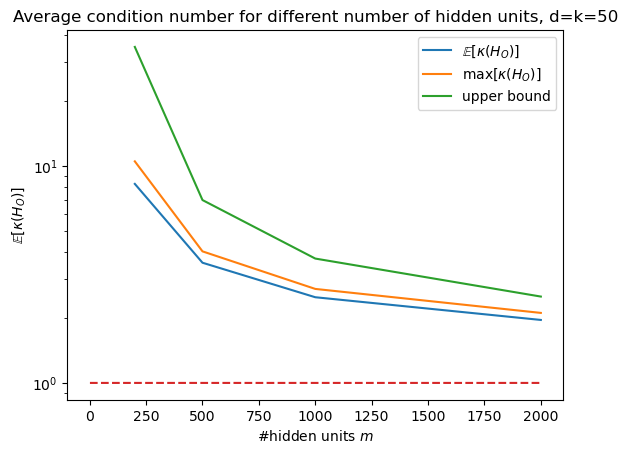

In [36]:
plt.semilogy(ms,[np.mean(H_o_tilde_cond_kaiming_1hl[l]) for l in range(len(ms))], label='$\mathbb{E}[\kappa(H_O)]$')
plt.semilogy(ms,[np.max(H_o_tilde_cond_kaiming_1hl[l]) for l in range(len(ms))], label='$\max[\kappa(H_O)]$')

plt.semilogy(ms,upperbound, label='upper bound')
# plt.ylim([7,10])
plt.semilogy(np.arange(1,2001),np.ones((2000,)),'--')

plt.xlabel('#hidden units $m$')
plt.ylabel('$\mathbb{E}[\kappa(H_O)]$')
plt.title('Average condition number for different number of hidden units, d=k=50')
plt.legend()

plt.savefig('figures/avg_condition_number_and_upper_bound_1_hidden_layer.pdf', bbox_inches='tight')

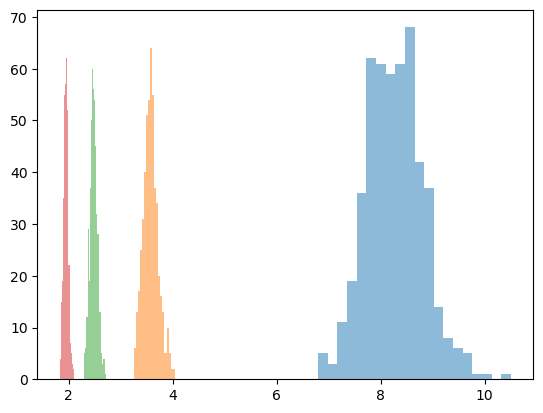

In [12]:
for ind, m in enumerate(ms):
    plt.hist(H_o_tilde_cond_kaiming_1hl[ind], alpha=0.5, bins=20, label='$\kappa_{kai}(\\tilde{{H}}_{kai,o,m={m}})$')


## 1-hidden linear layer: 
#### Testing the influence of the condition number of the input covariance matrix on the condition number of the outer product Hessian

Wide hidden layer: $m > \max\{d,k\}$

### input covariance $\sum_{i=1}^{n} x_ix_i^T = \Sigma_{xx}$

The input covariance is chosen to be $(\Sigma_{xx})_{ii} = 1$, for $i=1,...,d-1$, $(\Sigma_{xx})_{dd} = \kappa(\Sigma)$

From our theoretical results we could see that the upper bound of the condition number of the outer-product Hessian increases proportionally with the condition number of the input covariance matrix. 
In this section we test whether the condition number indeed increases proportionally with the condition number of the input covariance matrix.


In [15]:
d = 5 # input dimension
m = 50 # hidden layer dimension
k = 5 # output dimension
L = 0 # number of hidden layers of dim "m"
    
model_kaiming_init_1hl_cov = Linear_NN(d,m,k,L)
model_xavier_init_1hl_cov = Linear_NN(d,m,k,L)






In [16]:
from torch.distributions.multivariate_normal import MultivariateNormal

rep = 2000

H_o_tilde_cond_kaiming_1hl_cov = []
H_o_tilde_cond_xavier_1hl_cov = []

covs = [1, 10, 20, 50, 100, 200, 500, 1000, 2000, 5000]

for cv in range(len(covs)):
    
    start_timestamp = datetime.now()
    
    print('Calculations for kappa(Sigma) =', covs[cv])
    

    cov_x = torch.eye(d)
    cov_x[-1,-1] = covs[cv]

    # define multi-variate normal generator with unit matrix as variance
    mvrn_d = MultivariateNormal(torch.zeros(d),cov_x)
    mvrn_k = MultivariateNormal(torch.zeros(k),torch.eye(k))

    # sample n (input,output) tuples
    n = 10000
    x = mvrn_d.rsample((n,))    
    y = mvrn_k.rsample((n,))

    # calculate the empirical input covariance matrix and its condition number
    cov_xx = x.T @ x / n
    # repeat the calculation at initialization for "rep" times
    
    H_o_tilde_cond_kaiming_cov = []
    H_o_tilde_cond_xavier_cov = []
    
    for i in range(rep):

        if i%1000 == 0:
            print('iter: ', i)

        # initialize the weight matrices according to the defined initialization
        model_kaiming_init_1hl_cov.init_weights('kaiming_normal')
        model_xavier_init_1hl_cov.init_weights('xavier_normal')


        V_kaiming = model_kaiming_init_1hl_cov.lin_in.weight.detach()
        W_kaiming = model_kaiming_init_1hl_cov.lin_out.weight.detach()


        # calculate the outer Hessian product according to the expression derived by Sidak
        H_o_tilde_kaiming = torch.kron(W_kaiming@W_kaiming.T, cov_xx) + torch.kron( torch.eye(k), V_kaiming.T@V_kaiming@cov_xx)
        H_o_tilde_cond_kaiming_cov.append(torch.linalg.cond(H_o_tilde_kaiming))

        V_xavier = model_xavier_init_1hl_cov.lin_in.weight.detach()
        W_xavier = model_xavier_init_1hl_cov.lin_out.weight.detach()

        # calculate the outer Hessian product according to the expression derived by Sidak
        H_o_tilde_xavier = torch.kron(W_xavier@W_xavier.T, cov_xx) + torch.kron( torch.eye(k), V_xavier.T@V_xavier@cov_xx)
        H_o_tilde_cond_xavier_cov.append(torch.linalg.cond(H_o_tilde_xavier))

    H_o_tilde_cond_kaiming_1hl_cov.append(H_o_tilde_cond_kaiming_cov)
    H_o_tilde_cond_xavier_1hl_cov.append(H_o_tilde_cond_xavier_cov)
    
    print('Time elapsed: ',(datetime.now() - start_timestamp).total_seconds())

Calculations for kappa(Sigma) = 1
iter:  0
iter:  1000
Time elapsed:  0.460042
Calculations for kappa(Sigma) = 10
iter:  0
iter:  1000
Time elapsed:  0.430442
Calculations for kappa(Sigma) = 20
iter:  0
iter:  1000
Time elapsed:  0.430067
Calculations for kappa(Sigma) = 50
iter:  0
iter:  1000
Time elapsed:  0.427669
Calculations for kappa(Sigma) = 100
iter:  0
iter:  1000
Time elapsed:  0.42911
Calculations for kappa(Sigma) = 200
iter:  0
iter:  1000
Time elapsed:  0.427343
Calculations for kappa(Sigma) = 500
iter:  0
iter:  1000
Time elapsed:  0.429094
Calculations for kappa(Sigma) = 1000
iter:  0
iter:  1000
Time elapsed:  0.527044
Calculations for kappa(Sigma) = 2000
iter:  0
iter:  1000
Time elapsed:  0.427255
Calculations for kappa(Sigma) = 5000
iter:  0
iter:  1000
Time elapsed:  0.428974


In [17]:
H_o_tilde_cond_kaiming_means = [np.mean(H_o_tilde_cond_kaiming_1hl_cov[i]) for i in range(len(covs))]
H_o_tilde_cond_xavier_means = [np.mean(H_o_tilde_cond_xavier_1hl_cov[i]) for i in range(len(covs))]

Text(0.5, 1.0, 'Average condition number of the outer product Hessian plotted against the condition number of $\\Sigma$')

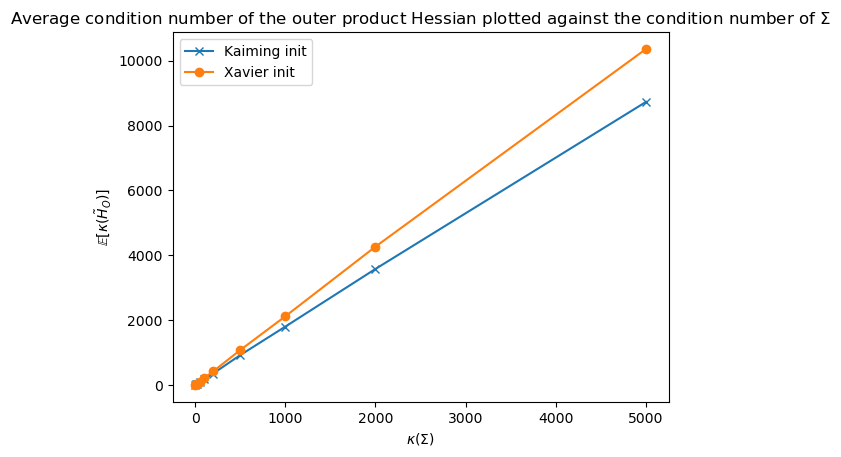

In [18]:
plt.plot(covs,H_o_tilde_cond_kaiming_means,'x-', label='Kaiming init')
plt.plot(covs,H_o_tilde_cond_xavier_means,'o-', label='Xavier init')
plt.legend()

plt.ylabel('$\mathbb{E}[\kappa(\\tilde{H}_O)]$')
plt.xlabel('$\kappa(\Sigma)$')
plt.title('Average condition number of the outer product Hessian plotted against the condition number of $\Sigma$')

The above plot was generated using a 1-hidden layer linear NN with $50$ hidden units and input dimension $5$ and output dimension $6$. Average was calculated over 2000 initializations (using the same input covariance matrix $\Sigma$)

**Conclusion**: The average condition number of the outer product Hessian does indeed increase proportionally with the condition number of the input covariance matrix.  

### 1-hidden linear layer: Evaluating the relationship between $m$ and $\kappa(H_O)$

We observed in one of the above sections that increasing the number of hidden units will improve the condition number of the outer product Hessian. Not only is the average condition number smaller, but it also gets more concentrated (i.e. smaller variance)

In this section, 
   1. I'm quantifying by how much the increase of hidden units benefit the condition number.
   2. How the tight the predicted upper bound is with varying number of hidden units.

Setting:
     
 - Wide hidden layer: $m > \max\{d,k\}$

 - input covariance $\sum_{i=1}^{n} x_ix_i^T = \Sigma_{xx} = I$

In [38]:
d = 5 # input dimension
m1 = [20, 40, 60, 80, 100, 200, 500, 1000, 5000] # hidden layer dimension
k = 5 # output dimension

L = 0 # number of hidden layers of dim "m"

num_param = [] # count the number of parameters in the model
Linear_Networks = []

# initiate linear networks of given depth L[l] with m1 hidden units each
for l in range(len(m1)):
    Linear_Networks.append(Linear_NN(d,m1[l],k,L))
    num_param.append(sum(p.numel() for p in Linear_NN(d,m1[l],k,L).parameters()))

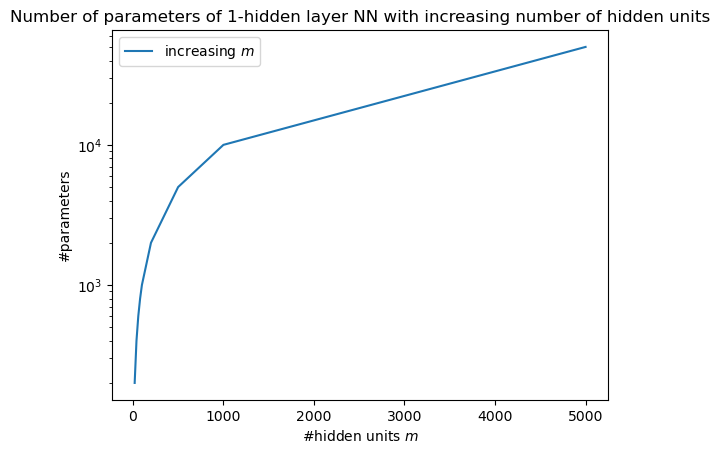

In [20]:
#'Note: For a constant number of hidden units, the number of parameters
#        increases linearly with the number of layers')


plt.semilogy(m1,num_param, label='increasing $m$')
plt.title('Number of parameters of 1-hidden layer NN with increasing number of hidden units')
plt.xlabel('#hidden units $m$')
plt.ylabel('#parameters')
plt.legend()

plt.savefig('figures/num_param_for_1_hidden_layer_increasing_m.pdf', bbox_inches='tight')

In [21]:
rep = 2000

H_o_tilde_cond_kaiming = []
H_o_cond_upper_bounds = []

cov_x = torch.eye(d)

# define multi-variate normal generator with unit matrix as variance
mvrn_d = MultivariateNormal(torch.zeros(d),cov_x)
mvrn_k = MultivariateNormal(torch.zeros(k),torch.eye(k))

# sample n (input,output) tuples
n = 10000
x = mvrn_d.rsample((n,))    
y = mvrn_k.rsample((n,))

# calculate the empirical input covariance matrix and its condition number
cov_xx = x.T @ x / n

cond_cov_xx = np.linalg.cond(cov_xx)

# do the calculations for each l in L
for l in range(len(m1)):
    print('Calculations for m=',m1[l])
    # repeat the calculation at initialization for "rep" times
    H_o_tilde_cond_l = []
    
    H_o_tilde_cond_l_upper_bound = []
    for i in range(rep):

        if i%1000 == 0:
            print('iter: ', i)

        # initialize the weight matrices according to the defined initialization
        Linear_Networks[l].init_weights('kaiming_normal')
        
        
        V_kaiming = Linear_Networks[l].lin_in.weight
        W_kaiming = Linear_Networks[l].lin_out.weight


        # calculate the outer Hessian product according to the expression derived by Sidak
        H_o_tilde = torch.kron(W_kaiming@W_kaiming.T, cov_xx) + torch.kron( torch.eye(k), V_kaiming.T@V_kaiming@cov_xx)
        H_o_tilde_cond_l.append(torch.linalg.cond(H_o_tilde.detach()))
              
    
    H_o_tilde_cond_kaiming.append(H_o_tilde_cond_l)
       


Calculations for m= 20
iter:  0
iter:  1000
Calculations for m= 40
iter:  0
iter:  1000
Calculations for m= 60
iter:  0
iter:  1000
Calculations for m= 80
iter:  0
iter:  1000
Calculations for m= 100
iter:  0
iter:  1000
Calculations for m= 200
iter:  0
iter:  1000
Calculations for m= 500
iter:  0
iter:  1000
Calculations for m= 1000
iter:  0
iter:  1000
Calculations for m= 5000
iter:  0
iter:  1000


In [22]:
display(Latex(f'Average condition number of the outer product Hessian for $\kappa(\Sigma) \\approx $ 1 for 1-hidden layer linear NN'))

for l in range(len(m1)):
    display(Latex(f'$\mathbb{{E}}[\kappa(\\tilde{{H}}_{{kai,o,m={m1[l]}}})]={np.mean(H_o_tilde_cond_kaiming[l])}$'))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [39]:
t = 3
prob = 1 - 8 * np.exp(-t**2/2)
m = np.array(m1)

kappa_sigma = 1

display(Latex(r'Upper bound of outer product Hessian with high probability: $p = 1 - 8 \exp(-t^2/2)$'))
display(Latex(f'For $t = {t}$, $p = {prob}$'))


# if np.minimum(np.sqrt(m)-np.sqrt(k)-t,np.sqrt(m)-np.sqrt(d)-t) < 0:
#     print('Invalid choice of t')

# else:

# Kaiming initialization
sigma2_w = 1/m
sigma2_v = 1/d

nominator = sigma2_w*(np.sqrt(m)+np.sqrt(k)+t)**2 + sigma2_v*(np.sqrt(m)+np.sqrt(d)+t)**2
denominator = sigma2_w*(np.sqrt(m)-np.sqrt(k)-t)**2 + sigma2_v*(np.sqrt(m)-np.sqrt(d)-t)**2

upperbound = kappa_sigma*(nominator/denominator)
for i in range(0,len(upperbound)):
    display(Latex(f'for m={m[i]}, upper bound for Kaiming initialization $\kappa(\hat{{H}}_{{O,Kai,m}}) \leq {upperbound[i]}$'))

# Xavier initialization
# sigma2_w = 2/(m+k)
# sigma2_v = 2/(m+d)

# nominator = sigma2_w*(np.sqrt(m)+np.sqrt(k)+t)**2 + sigma2_v*(np.sqrt(m)+np.sqrt(d)+t)**2
# denominator = sigma2_w*(np.sqrt(m)-np.sqrt(k)-t)**2 + sigma2_v*(np.sqrt(m)-np.sqrt(d)-t)**2

# upperbound = kappa_sigma*(nominator/denominator)
# for i in range(len(upperbound)):
#     display(Latex(f'for m={m[i]}, upper bound for Xavier initialization $\kappa(\hat{{H}}_{{O,Xav,m}}) \leq {upperbound[i]}$'))


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

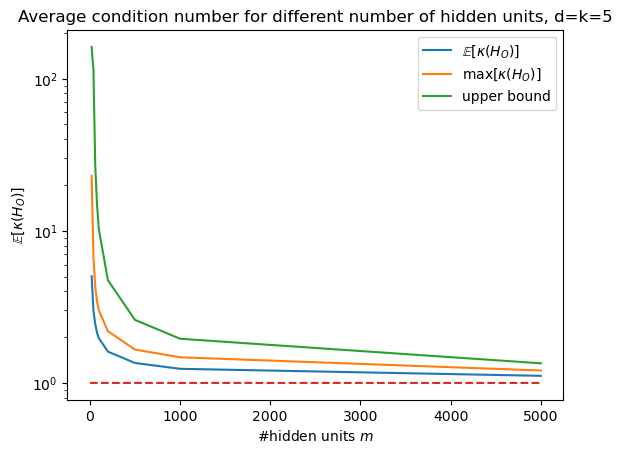

In [40]:
plt.semilogy(m1,[np.mean(H_o_tilde_cond_kaiming[l]) for l in range(len(m1))], label='$\mathbb{E}[\kappa(H_O)]$')
plt.semilogy(m1,[np.max(H_o_tilde_cond_kaiming[l]) for l in range(len(m1))], label='$\max[\kappa(H_O)]$')

plt.semilogy(m1,upperbound, label='upper bound')
# plt.ylim([7,10])
plt.semilogy(np.arange(1,5001),np.ones((5000,)),'--')

plt.xlabel('#hidden units $m$')
plt.ylabel('$\mathbb{E}[\kappa(H_O)]$')
plt.title('Average condition number for different number of hidden units, d=k=5')
plt.legend()

plt.savefig('figures/avg_condition_number_and_upper_bound_1_hidden_layer.pdf', bbox_inches='tight')

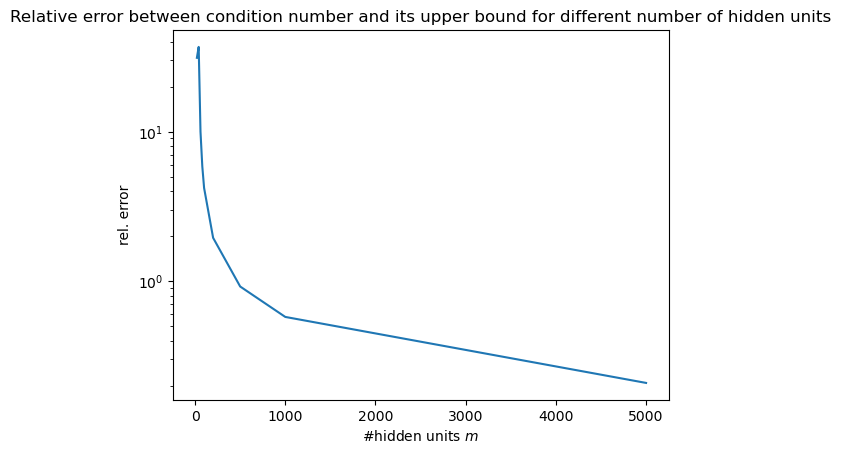

In [25]:
H_o_tilde_cond_mean = np.array([np.mean(H_o_tilde_cond_kaiming[l]) for l in range(len(m1))])

plt.semilogy(m1,(upperbound-H_o_tilde_cond_mean)/H_o_tilde_cond_mean)
plt.semilogy(np.arange(1,5001),np.zeros((5000,)),'--')

# plt.xlim([500,5000])
plt.xlabel('#hidden units $m$')
plt.ylabel('rel. error')
plt.title('Relative error between condition number and its upper bound for different number of hidden units')

plt.savefig('figures/rel_error_avg_condition_number_and_upper_bound_1_hidden_layer.pdf', bbox_inches='tight')

In [41]:
# display(Latex(f'Variance of condition number of the outer product Hessian for $\kappa(\Sigma) \\approx $ 1'))

# for l in range(len(m1)):
#     display(Latex(f'${{Var}}[\kappa(\\tilde{{H}}_{{kai,o,L={m1[l]}}})]={np.var(H_o_tilde_cond_kaiming[l])}$'))

Text(0.5, 1.0, 'Variance of distribution of condition number for different number of hidden units')

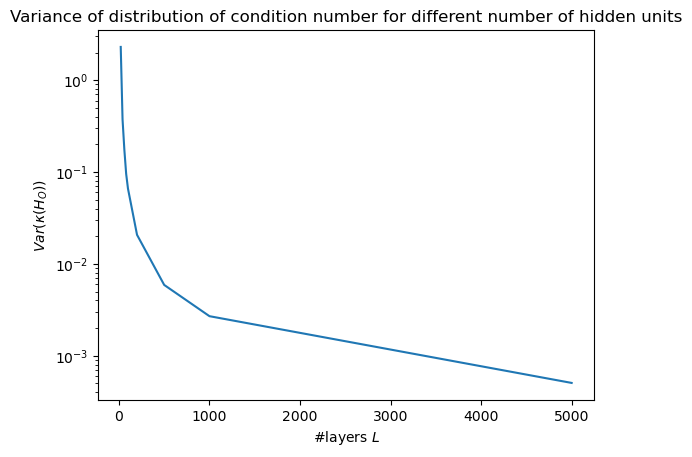

In [42]:
plt.semilogy(m1,[np.var(H_o_tilde_cond_kaiming[l]) for l in range(len(m1))])
# plt.ylim([5,10])

plt.xlabel('#layers $L$')
plt.ylabel('$Var(\kappa(H_O))$')
plt.title('Variance of distribution of condition number for different number of hidden units')

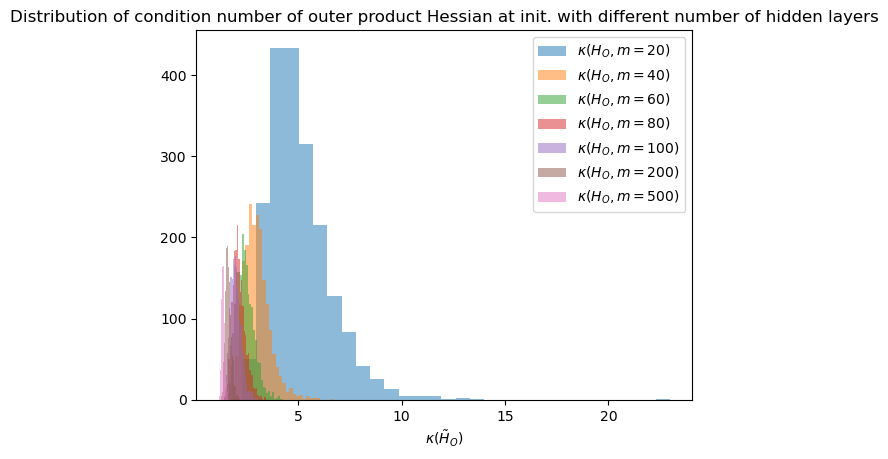

In [43]:
plt.hist(H_o_tilde_cond_kaiming[0], alpha=0.5, bins=30, label='$\kappa(H_O,m=20)$')
plt.hist(H_o_tilde_cond_kaiming[1], alpha=0.5, bins=30, label='$\kappa(H_O,m=40)$')
plt.hist(H_o_tilde_cond_kaiming[2], alpha=0.5, bins=30, label='$\kappa(H_O,m=60)$')
plt.hist(H_o_tilde_cond_kaiming[3], alpha=0.5, bins=30, label='$\kappa(H_O,m=80)$')
plt.hist(H_o_tilde_cond_kaiming[4], alpha=0.5, bins=30, label='$\kappa(H_O,m=100)$')
plt.hist(H_o_tilde_cond_kaiming[5], alpha=0.5, bins=30, label='$\kappa(H_O,m=200)$')
plt.hist(H_o_tilde_cond_kaiming[6], alpha=0.5, bins=30, label='$\kappa(H_O,m=500)$')
# plt.hist(H_o_tilde_cond_kaiming[7], alpha=0.5, bins=30, label='$\kappa(H_O,m=1000)$')
# plt.hist(H_o_tilde_cond_kaiming[8], alpha=0.5, bins=30, label='$\kappa(H_O,m=2000)$')
# plt.hist(H_o_tilde_cond_kaiming[9], alpha=0.5, bins=30, label='$\kappa(H_O,m=5000)$')


# plt.hist((H_o_cond_upper_bounds[0]), alpha=0.5, bins=30, label='upper bound for $L=0$')

plt.xlabel(f'$\kappa(\\tilde{{H}}_O)$')
plt.title(f'Distribution of condition number of outer product Hessian at init. with different number of hidden layers')
plt.legend()